# Coverage of viral tags and barcodes by Illumina 10X reads
This Python Jupyter notebook examines where the 10X aligned FASTQ reads fall on the viral genes (coverage) with respect to viral barcodes and viral tags.
It also writes information on the locations of the viral barcodes and tags in the viral genes.

## Parameters
First, set the parameters for the notebook, such as to specify the input files and output plots.
This is done in the next cell, which is tagged as a `parameters` cell to enable [papermill parameterization](https://papermill.readthedocs.io/en/latest/usage-parameterize.html):

In [1]:
# parameters cell; in order for notebook to run this cell must define:
#  - samples_10x: list of 10X samples
#  - input_fastq10x_bams: list of BAM file with alignments of 10X reads for each sample
#  - input_fastq10x_bais: BAM indices for each file in `input_fastq10x_bam`
#  - input_viral_genome: Genbank file with annotated viral genes
samples_10x = ['wt_virus_pilot']
input_fastq10x_bams = ['results/aligned_fastq10x/wt_virus_pilot/Aligned.sortedByCoord.out.bam']
input_fastq10x_bais = ['results/aligned_fastq10x/wt_virus_pilot/Aligned.sortedByCoord.out.bam.bai']
input_viral_genome = 'data/flu_sequences/flu-CA09.gb'

Check input lists all the right length, then make dicts that map sample names to BAM and BAM index files:

In [2]:
assert len(samples_10x) == len(input_fastq10x_bams) == len(input_fastq10x_bais)

fastq10x_bams = dict(zip(samples_10x, input_fastq10x_bams))
fastq10x_bais = dict(zip(samples_10x, input_fastq10x_bais))

## Import Python modules
We use [pysam](https://pysam.readthedocs.io/) to plot process the BAM files, [dna_features_viewer](https://edinburgh-genome-foundry.github.io/DnaFeaturesViewer/) for genes, and [plotnine](https://plotnine.readthedocs.io/) for some ggplot2-style plotting:

In [3]:
import collections
import itertools

import Bio.SeqIO

import dna_features_viewer

from IPython.display import display, HTML

import matplotlib
import matplotlib.pyplot as plt

import mizani

import pandas as pd

from plotnine import *

import pysam

Color-blind palette:

In [4]:
cbpalette = ('#999999', '#E69F00', '#56B4E9', '#009E73',
             '#F0E442', '#0072B2', '#D55E00', '#CC79A7')

Set [plotnine theme](https://plotnine.readthedocs.io/en/stable/api.html#themes):

In [5]:
_ = theme_set(theme_classic)

## Read the viral genes
Get all the viral genes as [BioPython SeqRecords](https://biopython.org/wiki/SeqRecord):

In [6]:
print(f"Reading viral genes from {input_viral_genome}")
viral_genes = list(Bio.SeqIO.parse(input_viral_genome, 'genbank'))
viral_gene_names = [s.id for s in viral_genes]
print(f"Found {len(viral_gene_names)} viral genes:\n\t" +
      '\n\t'.join(viral_gene_names))
assert len(viral_genes) == len(set(viral_gene_names)), 'viral gene names not unique'

Reading viral genes from data/flu_sequences/flu-CA09.gb
Found 8 viral genes:
	fluPB2
	fluPB1
	fluPA
	fluHA
	fluNP
	fluNA
	fluM
	fluNS


## Get viral tag and barcode locations
Get the locations of the viral tags and barcodes for each gene in 1-based indexing inclusive of the first and last number (so the type of numbering that Genbank files use):

In [7]:
viraltag_df = []
viralbc_df = []
for seqrecord in viral_genes:
    for f in seqrecord.features:
        if f.type == 'viral_barcode':
            viralbc_df.append([seqrecord.id, int(f.location.start) + 1, int(f.location.end)])
        elif 'tag' in f.type:
            viraltag_df.append((seqrecord.id, f.type, int(f.location.start) + 1, int(f.location.end)))
            
viraltag_df = pd.DataFrame.from_records(viraltag_df,
                                        columns=['gene', 'tag_name', 'start', 'end'])
assert len(viraltag_df) == len(viraltag_df.drop_duplicates())
print('\nHere the viral tag locations:')
display(HTML(viraltag_df.to_html(index=False)))

viralbc_df = pd.DataFrame.from_records(viralbc_df,
                                       columns=['gene', 'start', 'end'])
assert len(viralbc_df) == len(viralbc_df.drop_duplicates())
print('\nHere the viral barcode locations:')
display(HTML(viralbc_df.to_html(index=False)))


Here the viral tag locations:


gene,tag_name,start,end
fluPB2,tag_1,201,201
fluPB2,tag_2,2190,2190
fluPB1,tag_1,192,192
fluPB1,tag_2,2205,2205
fluPA,tag_1,123,123
fluPA,tag_2,2104,2104
fluHA,tag_1,249,249
fluHA,tag_2,1686,1686
fluNP,tag_1,132,132
fluNP,tag_2,1407,1407



Here the viral barcode locations:


gene,start,end
fluHA,1828,1843
fluNA,1551,1566


## Get alignment statistics for each gene and sample
Use [pysam](https://pysam.readthedocs.io/) to get the following dataframes:
 - `nreads_df`: total number of reads aligned to each gene in each sample
 - `coverage_df`: coverage at each site for each viral gene in each sample
 - `readlen_df`: distribution of lengths of the **aligned** portion of reads (not including soft-clipped bases) for each gene in each sample

In [8]:
coverage_list = []
nreads_list = []
readlen_list = []

for viral_gene, sample10x in itertools.product(viral_genes, samples_10x):
    gene_name = viral_gene.id
    bam = fastq10x_bams[sample10x]
    bai = fastq10x_bais[sample10x]
    print(f"Getting statistics for {gene_name} in {sample10x} from {bam}")
    
    with pysam.AlignmentFile(bam, mode='rb', index_filename=bai) as bamfile:
        if len(viral_gene) != bamfile.get_reference_length(gene_name):
            raise ValueError(f"length of {gene_name} not as expected in {bam}")
            
        nreads_list.append(
                pd.DataFrame({'gene': [gene_name],
                              'sample': [sample10x],
                              'nreads': [bamfile.count(contig=gene_name)],
                              })
                ) 

        coverage_list.append(
                pd.DataFrame(dict(zip('ACGT',
                                      bamfile.count_coverage(contig=gene_name))))
                .assign(depth=lambda x: x.sum(axis=1),
                        site=lambda x: x.index + 1,
                        gene=gene_name,
                        sample=sample10x)
                [['gene', 'sample', 'site', 'depth']]
                )
        
        readlens = collections.defaultdict(int)
        for read in bamfile.fetch(contig=gene_name):
            readlens[read.query_alignment_length] += 1
        readlen_list.append(
                pd.DataFrame.from_records(list(readlens.items()),
                                          columns=['aligned_read_length', 'nreads'])
                .assign(gene=gene_name,
                        sample=sample10x)
                .sort_values('aligned_read_length')
                [['gene', 'sample', 'aligned_read_length', 'nreads']]
                )
        
nreads_df = (pd.concat(nreads_list, sort=False, ignore_index=True)
             .assign(gene=lambda x: pd.Categorical(x['gene'],
                                                   viral_gene_names,
                                                   ordered=True))
             )
print('\nFirst few lines of `nreads_df`:')
display(HTML(nreads_df.head().to_html(index=False)))
        
coverage_df = (pd.concat(coverage_list, sort=False, ignore_index=True)
               .assign(gene=lambda x: pd.Categorical(x['gene'],
                                                     viral_gene_names,
                                                     ordered=True))
               )
print('\nFirst few lines of `coverage_df`:')
display(HTML(coverage_df.head().to_html(index=False)))

readlen_df = (pd.concat(readlen_list, sort=False, ignore_index=True)
              .assign(gene=lambda x: pd.Categorical(x['gene'],
                                                    viral_gene_names,
                                                    ordered=True))
              )
print('\nFirst few lines of `readlen_df`:')
display(HTML(readlen_df.head().to_html(index=False)))

Getting statistics for fluPB2 in wt_virus_pilot from results/aligned_fastq10x/wt_virus_pilot/Aligned.sortedByCoord.out.bam
Getting statistics for fluPB1 in wt_virus_pilot from results/aligned_fastq10x/wt_virus_pilot/Aligned.sortedByCoord.out.bam
Getting statistics for fluPA in wt_virus_pilot from results/aligned_fastq10x/wt_virus_pilot/Aligned.sortedByCoord.out.bam
Getting statistics for fluHA in wt_virus_pilot from results/aligned_fastq10x/wt_virus_pilot/Aligned.sortedByCoord.out.bam
Getting statistics for fluNP in wt_virus_pilot from results/aligned_fastq10x/wt_virus_pilot/Aligned.sortedByCoord.out.bam
Getting statistics for fluNA in wt_virus_pilot from results/aligned_fastq10x/wt_virus_pilot/Aligned.sortedByCoord.out.bam
Getting statistics for fluM in wt_virus_pilot from results/aligned_fastq10x/wt_virus_pilot/Aligned.sortedByCoord.out.bam
Getting statistics for fluNS in wt_virus_pilot from results/aligned_fastq10x/wt_virus_pilot/Aligned.sortedByCoord.out.bam

First few lines of `nr

gene,sample,nreads
fluPB2,wt_virus_pilot,2312
fluPB1,wt_virus_pilot,6515
fluPA,wt_virus_pilot,2040
fluHA,wt_virus_pilot,14763
fluNP,wt_virus_pilot,46121



First few lines of `coverage_df`:


gene,sample,site,depth
fluPB2,wt_virus_pilot,1,34
fluPB2,wt_virus_pilot,2,90
fluPB2,wt_virus_pilot,3,87
fluPB2,wt_virus_pilot,4,91
fluPB2,wt_virus_pilot,5,89



First few lines of `readlen_df`:


gene,sample,aligned_read_length,nreads
fluPB2,wt_virus_pilot,81,32
fluPB2,wt_virus_pilot,82,24
fluPB2,wt_virus_pilot,83,17
fluPB2,wt_virus_pilot,84,9
fluPB2,wt_virus_pilot,85,8


Sanity check to make sure we got the right number of sites for each gene in `coverage_df`:

In [9]:
for viral_gene in viral_genes:
    gene_name = viral_gene.id
    lengths = (coverage_df
               .query('gene == @gene_name')
               .groupby('sample')
               .size()
               .values
               )
    if not all(lengths == len(viral_gene)):
        raise ValueError(f"coverage not for expected number sites for {gene_name}")

Sanity check to make sure `nreads_df` and `readlen_df` have same number of reads:

In [10]:
if not all(nreads_df['nreads'].values == (readlen_df
                                          .groupby(['gene', 'sample'],
                                                   sort=False)
                                          .aggregate({'nreads': 'sum'})
                                          ['nreads']
                                          .values
                                          )):
    raise ValueError('nreads differ for `nreads_df` and `readlen_df`')

## Total reads per viral gene
Plot the total number of aligned reads for each viral gene:

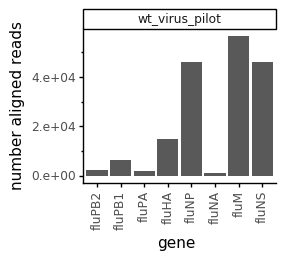

In [11]:
p = (ggplot(nreads_df, aes('gene', 'nreads')) +
     geom_bar(stat='identity') +
     facet_wrap('~ sample', nrow=1) +
     theme(figure_size=(2.5 * len(samples_10x), 2),
           axis_text_x=element_text(angle=90)) +
     scale_y_continuous(labels=mizani.formatters.scientific_format(),
                        name='number aligned reads')
     )

_ = p.draw()

## Lengths of aligned reads for each viral gene
Plot the distribution of the lengths of the **aligned** portions of each read for each viral gene:

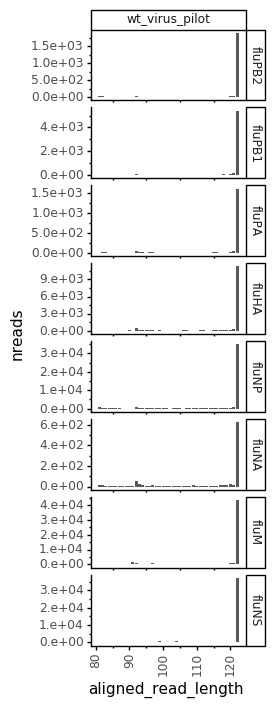

In [12]:
p = (ggplot(readlen_df, aes('aligned_read_length', 'nreads')) +
     geom_bar(stat='identity') +
     facet_grid('gene ~ sample', scales='free_y') +
     theme(figure_size=(2 * len(samples_10x), 1 * len(viral_gene_names)),
           axis_text_x=element_text(angle=90)) +
     scale_y_continuous(labels=mizani.formatters.scientific_format())
     )

_ = p.draw()

## Coverage per site, including over viral tags and barcodes
Now plot depth per site alongside gene structure.
In this plot, we indicate the viral tags (blue) and viral barcodes (orange):

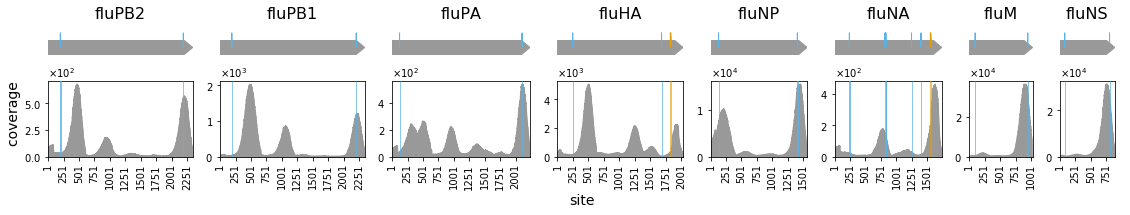

In [31]:
# set up grid of subplots
gene_lengths = [len(viral_gene) for viral_gene in viral_genes]
gene_image_relheight = 0.2
fig, axes = plt.subplots(nrows=1 + len(samples_10x),
                         ncols=len(viral_gene_names),
                         sharex='col',
                         gridspec_kw={'width_ratios': gene_lengths,
                                      'height_ratios': [1] + [2.5] * len(samples_10x)},
                         figsize=(16, 3 * (len(samples_10x) + gene_image_relheight)),
                         squeeze=False,
                         )

# plot genes in first row, only showing full vRNA, viral barcodes, and tags
# first define a translator from the sequence record to graphic record
class ViralGeneTranslator(dna_features_viewer.BiopythonTranslator):
    """Translate BioPython SeqRecord into GraphicRecord.""" 
    def compute_feature_color(self, feature):
        if feature.type == 'exon':
            return cbpalette[0]
        elif feature.type == 'viral_barcode':
            return cbpalette[1]
        elif 'tag' in feature.type:
            return cbpalette[2]
        else:
            return cbpalette[3]

    def compute_feature_label(self, feature):
        return None
    
    def compute_filtered_features(self, features):
        return [f for f in features 
                if f.type in ['exon', 'viral_barcode'] or 'tag' in f.type]
    
# now plot the genes in the first row of the subplots
for ax, seqrecord in zip(axes[: 1,].ravel(), viral_genes):
    graphic_record = ViralGeneTranslator().translate_record(seqrecord)
    for f in graphic_record.features:
        f.linecolor = f.color
    graphic_record.plot(ax=ax, with_ruler=False, draw_line=False)
    ax.set_title(seqrecord.id, fontsize=16)

# plot coverage on subplots not in first row
for ax, (sample, gene) in zip(axes[1:,].ravel(),
                              itertools.product(samples_10x, viral_gene_names)):
    
    # plot coverage
    (coverage_df
     .query('(sample == @sample) & (gene == @gene)')
     .plot(ax=ax,
           x='site',
           y='depth',
           kind='area',
           legend=False,
           color=cbpalette[0],
           )
     )
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0), useMathText=True)
    if sample == samples_10x[-1]:
        xticklocs = list(range(1, int(ax.get_xlim()[1]), 250))
        ax.set_xticks(ticks=xticklocs)
        ax.tick_params(axis='x', labelrotation=90)
    else:
        ax.set_xticklabels([])

    # plot viral barcodes
    ymin, ymax = ax.get_ylim()
    for tup in viralbc_df.query('gene == @gene').itertuples():
        rect = matplotlib.patches.Rectangle(xy=(tup.start, ymin),
                                            width=tup.end - tup.start + 1,
                                            height=ymax,
                                            color=cbpalette[1],
                                            zorder=4,
                                            alpha=0.5)
        ax.add_patch(rect)
        
    # plot viral tags
    ymin, ymax = ax.get_ylim()
    for tup in viraltag_df.query('gene == @gene').itertuples():
        rect = matplotlib.patches.Rectangle(xy=(tup.start, ymin),
                                            width=tup.end - tup.start + 1,
                                            height=ymax,
                                            color=cbpalette[2],
                                            zorder=4,
                                            alpha=0.7)
        ax.add_patch(rect)
        
# shared x- and y-labels following here: https://stackoverflow.com/a/53172335
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('\nsite', size=14)
plt.ylabel('coverage          ', size=14)

fig.tight_layout(w_pad=0)
display(fig)
plt.close(fig)